# Classification of Inappropriate/Offensive Text

## Import the essentials

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import zeyrek
import re
import contextlib
import io
from tqdm import tqdm

# Text vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from radient import text_vectorizer

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

# Bernoulli for bag-of-words, Multinomial for Tf-idf and Gaussian for sentence transformers
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

# MLP Classifier for sentence transformers
from sklearn.neural_network import MLPClassifier

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

@contextlib.contextmanager
def suppress_output():
    with contextlib.redirect_stdout(io.StringIO()) as stdout, \
         contextlib.redirect_stderr(io.StringIO()) as stderr:
        yield (stdout, stderr)

nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
data = pd.read_csv('dataset.csv')
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,Gerçekten sizin hikayelerinizi izleyerek mi ye...,0
1,@USER Çoook çok bi baklava bi sen zaten,0
2,"1) Sn. DÜKEL; Atatürk'ün, Karma E. M. ile başl...",0
3,Konfederasyonumuzun Aile ve Sosyal Politikalar...,0
4,Hakemler tarih yazıyorlar / 9 kişiye karşı 3-2...,1


## Data Preprocessing Part

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53005 entries, 0 to 53004
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    53005 non-null  object
 1   label   53005 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 828.3+ KB


In [3]:

analyzer = zeyrek.MorphAnalyzer()

# Function to remove unnecessary user tags from the entries
def clean_text(text):
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-ZçğıöşüÇĞİÖŞÜ\s]', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('turkish'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    lemmatized_words = []
    for word in words:
        with suppress_output():
            analyses = analyzer.analyze(word)
        if analyses:
            lemmatized_words.append(analyses[0][0].lemma)
        else:
            lemmatized_words.append(word)
    
    return ' '.join(lemmatized_words)

# Apply the cleaning function to the 'text' column
data['text'] = data['text'].apply(clean_text)


In [4]:
# Lowercase all words and remove unknown tokens: 'unk'
# Function to convert match to lowercase
to_lowercase = lambda match: match.group(0).lower()
rem_words = ['unk', 'Unk', 'user']
for i in range(data['text'].size):
    data['text'].iloc[i] = re.sub(r'.', to_lowercase, data['text'].iloc[i])

    # Remove unk tokens
    data['text'].iloc[i] = re.sub(r'\bunk\s|\sunk\b', '', data['text'].iloc[i])
    data['text'].iloc[i] = re.sub(r'\sunk\s', ' ', data['text'].iloc[i])
    data['text'].iloc[i] = re.sub(r'\bUnk\s|\sUnk\b', '', data['text'].iloc[i])
    data['text'].iloc[i] = re.sub(r'\sUnk\s', ' ', data['text'].iloc[i])
    

# Save the cleaned dataframe
data.to_csv('cleaned_dataset.csv', index=False)

C:\Users\snake\AppData\Local\Temp\ipykernel_9720\3470312949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'].iloc[i] = re.sub(r'.', to_lowercase, data['text'].iloc[i])
C:\Users\snake\AppData\Local\Temp\ipykernel_9720\3470312949.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'].iloc[i] = re.sub(r'\bunk\s|\sunk\b', '', data['text'].iloc[i])
C:\Users\snake\AppData\Local\Temp\ipykernel_9720\3470312949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

## Exploratory Data Analysis Results
The dataset includes 53005 rows and is about to offensive text. We can clearly see that our data has 2 columns which are not null: *text* and *label*. So we don't need to clear or fill the null values.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,53005.0,0.463692,0.498685,0.0,0.0,0.0,1.0,1.0


### Most used words

In [6]:
def find_most_common(data, number = 50):
  words_filter = ['@', '.', 'USER', 'user','ve', 'bir', 'bu', 'Bu', 'de', 'ne', 'se', '!' ':', 'https', '"', '...', '``']
  text_list = data['text'].tolist()

  # Join all the strings in the list into a single string
  text = ' '.join(text_list)

  # Tokenize the text into words
  words = nltk.word_tokenize(text)
  # Count the frequency of each word
  freq_dist = FreqDist(words)
  stopwords = nltk.corpus.stopwords.words('turkish')
  dict_filter = lambda freq_dist, stopwords: dict( (word,freq_dist[word]) for word in freq_dist if (word not in stopwords and word not in words_filter and len(word) > 1) )
  filtered_freq_dist = dict_filter(freq_dist, stopwords)

  print(type(filtered_freq_dist))
  # Get the most frequent words
  most_frequent_words = FreqDist(filtered_freq_dist).most_common(number)
  return most_frequent_words

In [7]:
# Filter the symbols and most common adjuncts in Turkish
# Convert the text column to a list of strings
data_offensive = data[data['label'] == 1]
data_not_offensive = data[data['label'] == 0]

most_frequent_words_in_offensive = find_most_common(data_offensive)
most_frequent_words_not_in_offensive = find_most_common(data_not_offensive)

<class 'dict'>
<class 'dict'>


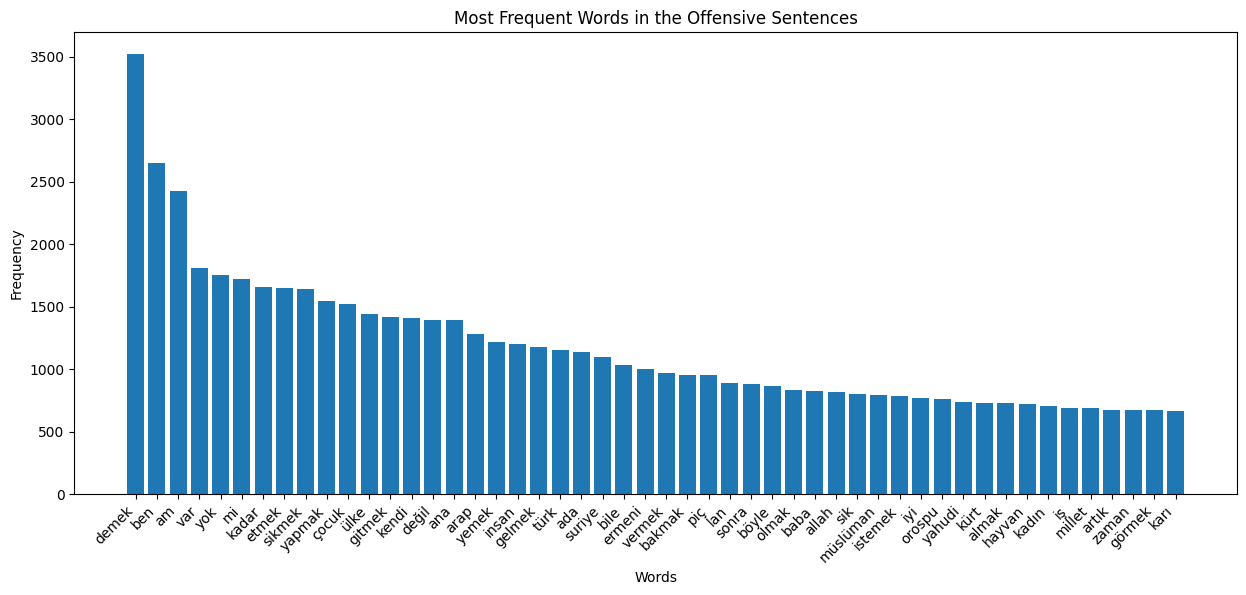

In [8]:
# Extract the words and frequencies from the most_frequent_words list
words, frequencies = zip(*most_frequent_words_in_offensive)

# Create a bar chart of the most frequent words
plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Most Frequent Words in the Offensive Sentences")
plt.show()

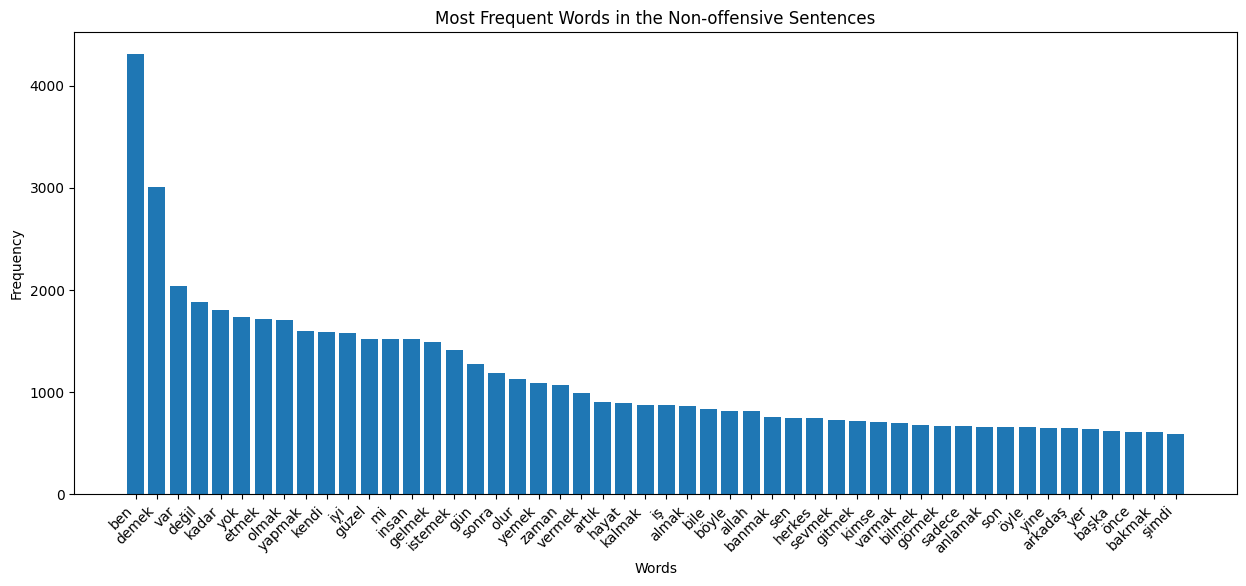

In [9]:
# Extract the words and frequencies from the most_frequent_words list
words, frequencies = zip(*most_frequent_words_not_in_offensive)

# Create a bar chart of the most frequent words
plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Most Frequent Words in the Non-offensive Sentences")
plt.show()

In [10]:
# Use bag-of-words method to vectorize text
# 'bow' signifies the bag-of-words 

data = pd.read_csv('cleaned_dataset.csv', encoding='utf-8')
vectorizer_bow = CountVectorizer(encoding='utf-8')
X_bow = vectorizer_bow.fit_transform(data['text'].values.astype(str))

# use bool type for each numeric to reduce size

X_bow = X_bow.astype(bool).toarray()

In [11]:
# Use Tf-idf vectorizer
# 'idf' refers to the Tf-idf vectorizer

vectorizer_idf = TfidfVectorizer(encoding='utf-8')
X_idf = vectorizer_idf.fit_transform(data['text'].values.astype(str))

In [12]:
# Use 'BGE-M3' model from sentence-transformers to vectorize raw sentences
# The results are vectors with 1024-dimensions. 'st' signifies the sentence transformers

X_st= []
vectorizer_st = text_vectorizer(method="sbert", model_name_or_path="BAAI/bge-m3")
data_raw = pd.read_csv('dataset.csv', encoding='utf-8')
for row in tqdm(data_raw['text'], total=data_raw.shape[0]):
    X_st.append(vectorizer_st.vectorize(str(row)))

c:\Users\snake\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\snake\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 53005/53005 [19:02<00:00, 46.38it/s]


In [13]:
# Split the resulting datasets for training and testing


X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, data['label'].astype(bool), test_size=0.2, stratify=data['label'])
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(X_idf, data['label'].astype(bool), test_size=0.2, stratify=data['label'])
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, data['label'].astype(bool), test_size=0.2, stratify=data['label'])

Model training and evaluation for Bag-of-words method

In [14]:
# Decision tree

model_bow_dt = DecisionTreeClassifier(max_depth=10)
model_bow_dt.fit(X_train_bow, y_train_bow)
predictions_bow_dt = model_bow_dt.predict(X_test_bow)
accuracy_bow_dt = accuracy_score(y_test_bow, predictions_bow_dt)
print(accuracy_bow_dt)

0.6842750683897746


In [15]:
# Random forest

model_bow_rf = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=2)
model_bow_rf.fit(X_train_bow, y_train_bow)
predictions_bow_rf = model_bow_rf.predict(X_test_bow)
accuracy_bow_rf = accuracy_score(y_test_bow, predictions_bow_rf)
print(accuracy_bow_rf)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
0.7233279879256674


In [16]:
# Naive bayes

model_bow_nb = BernoulliNB()
model_bow_nb.fit(X_train_bow, y_train_bow)
predictions_bow_nb = model_bow_nb.predict(X_test_bow)
accuracy_bow_nb = accuracy_score(y_test_bow, predictions_bow_nb)
print(accuracy_bow_nb)

0.8570889538722762


In [17]:
# Multilayer perceptron

model_bow_mlp = MLPClassifier(hidden_layer_sizes=[64,64,64, 2], verbose=2)
model_bow_mlp.fit(X_train_bow, y_train_bow)
predictions_bow_mlp = model_bow_mlp.predict(X_test_bow)
accuracy_bow_mlp = accuracy_score(y_test_bow, predictions_bow_mlp)
print(accuracy_bow_mlp)

Iteration 1, loss = 0.50946503
Iteration 2, loss = 0.35505260
Iteration 3, loss = 0.29493997
Iteration 4, loss = 0.23150960
Iteration 5, loss = 0.17946329
Iteration 6, loss = 0.14125351
Iteration 7, loss = 0.11761187
Iteration 8, loss = 0.10251485
Iteration 9, loss = 0.09507757
Iteration 10, loss = 0.08863692
Iteration 11, loss = 0.08323735
Iteration 12, loss = 0.08246244
Iteration 13, loss = 0.08042273
Iteration 14, loss = 0.07585403
Iteration 15, loss = 0.07281391
Iteration 16, loss = 0.07145135
Iteration 17, loss = 0.06919998
Iteration 18, loss = 0.06795510
Iteration 19, loss = 0.06760355
Iteration 20, loss = 0.06656045
Iteration 21, loss = 0.06593802
Iteration 22, loss = 0.06686605
Iteration 23, loss = 0.06685979
Iteration 24, loss = 0.06752995
Iteration 25, loss = 0.06562193
Iteration 26, loss = 0.06458847
Iteration 27, loss = 0.06389179
Iteration 28, loss = 0.06298452
Iteration 29, loss = 0.06330199
Iteration 30, loss = 0.06121985
Iteration 31, loss = 0.06014571
Iteration 32, los

Model training and evaluation for Tf-idf method

In [18]:
# Decision tree

model_idf_dt = DecisionTreeClassifier(max_depth=10)
model_idf_dt.fit(X_train_idf, y_train_idf)
predictions_idf_dt = model_idf_dt.predict(X_test_idf)
accuracy_idf_dt = accuracy_score(y_test_idf, predictions_idf_dt)
print(accuracy_idf_dt)

0.6774832562965758


In [19]:
# Random forest

model_idf_rf = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=2)
model_idf_rf.fit(X_train_idf, y_train_idf)
predictions_idf_rf = model_idf_rf.predict(X_test_idf)
accuracy_idf_rf = accuracy_score(y_test_idf, predictions_idf_rf)
print(accuracy_idf_rf)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
0.6951231015941892


In [20]:
# Naive bayes

model_idf_nb = MultinomialNB()
model_idf_nb.fit(X_train_idf, y_train_idf)
predictions_idf_nb = model_idf_nb.predict(X_test_idf)
accuracy_idf_nb = accuracy_score(y_test_idf, predictions_idf_nb)
print(accuracy_idf_nb)


0.8502028110555608


In [39]:
# Multilayer perceptron

model_idf_mlp = MLPClassifier(hidden_layer_sizes=[64,64,64, 2], verbose=2)
model_idf_mlp.fit(X_train_idf, y_train_idf)
predictions_idf_mlp = model_idf_mlp.predict(X_test_idf)
accuracy_idf_mlp = accuracy_score(y_test_idf, predictions_idf_mlp)
print(accuracy_idf_mlp)

Iteration 1, loss = 0.47949472
Iteration 2, loss = 0.33849523
Iteration 3, loss = 0.29745885
Iteration 4, loss = 0.27111341
Iteration 5, loss = 0.25038864
Iteration 6, loss = 0.23229586
Iteration 7, loss = 0.21662349
Iteration 8, loss = 0.20400113
Iteration 9, loss = 0.19340924
Iteration 10, loss = 0.18634609
Iteration 11, loss = 0.18185778
Iteration 12, loss = 0.18020909
Iteration 13, loss = 0.17928106
Iteration 14, loss = 0.17937395
Iteration 15, loss = 0.17692281
Iteration 16, loss = 0.17562981
Iteration 17, loss = 0.17466792
Iteration 18, loss = 0.17423904
Iteration 19, loss = 0.17429182
Iteration 20, loss = 0.17334089
Iteration 21, loss = 0.17370865
Iteration 22, loss = 0.17245296
Iteration 23, loss = 0.17305125
Iteration 24, loss = 0.17378669
Iteration 25, loss = 0.17348640
Iteration 26, loss = 0.17315517
Iteration 27, loss = 0.17186071
Iteration 28, loss = 0.17137846
Iteration 29, loss = 0.17059518
Iteration 30, loss = 0.17058134
Iteration 31, loss = 0.17009114
Iteration 32, los

Model training and evaluation for Sentence Transformers method

In [22]:
# Decision tree

model_st_dt = DecisionTreeClassifier(max_depth=10)
model_st_dt.fit(X_train_st, y_train_st)
predictions_st_dt = model_st_dt.predict(X_test_st)
accuracy_st_dt = accuracy_score(y_test_st, predictions_st_dt)
print(accuracy_st_dt)

0.7413451561173474


In [23]:
# Random forest

model_st_rf = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=2)
model_st_rf.fit(X_train_st, y_train_st)
predictions_st_rf = model_st_rf.predict(X_test_st)
accuracy_st_rf = accuracy_score(y_test_st, predictions_st_rf)
print(accuracy_st_rf)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
0.8100179228374682


In [24]:
# Naive bayes

model_st_nb = GaussianNB()
model_st_nb.fit(X_train_st, y_train_st)
predictions_st_nb = model_st_nb.predict(X_test_st)
accuracy_st_nb = accuracy_score(y_test_st, predictions_st_nb)
print(accuracy_st_nb)


0.8447316290915952


In [25]:
# Multilayer perceptron

model_st_mlp = MLPClassifier(hidden_layer_sizes=[64,64,64, 2], verbose=2)
model_st_mlp.fit(X_train_st, y_train_st)
predictions_st_mlp = model_st_mlp.predict(X_test_st)
accuracy_st_mlp = accuracy_score(y_test_st, predictions_st_mlp)
print(accuracy_st_mlp)


Iteration 1, loss = 0.44507693
Iteration 2, loss = 0.36296791
Iteration 3, loss = 0.34382971
Iteration 4, loss = 0.32667486
Iteration 5, loss = 0.31011349
Iteration 6, loss = 0.29535970
Iteration 7, loss = 0.27860272
Iteration 8, loss = 0.26405254
Iteration 9, loss = 0.25077558
Iteration 10, loss = 0.23477763
Iteration 11, loss = 0.22491447
Iteration 12, loss = 0.20846463
Iteration 13, loss = 0.19346449
Iteration 14, loss = 0.18562576
Iteration 15, loss = 0.16925937
Iteration 16, loss = 0.15918122
Iteration 17, loss = 0.14691668
Iteration 18, loss = 0.14458999
Iteration 19, loss = 0.12487050
Iteration 20, loss = 0.11823370
Iteration 21, loss = 0.12632045
Iteration 22, loss = 0.10115247
Iteration 23, loss = 0.09432770
Iteration 24, loss = 0.09198105
Iteration 25, loss = 0.11664336
Iteration 26, loss = 0.08406636
Iteration 27, loss = 0.07122428
Iteration 28, loss = 0.06657848
Iteration 29, loss = 0.06126695
Iteration 30, loss = 0.05918891
Iteration 31, loss = 0.06012535
Iteration 32, los

Evaluation of results - Bag-of-words

               precision    recall  f1-score   support

Non-offensive       0.63      1.00      0.77      5685
    Offensive       0.98      0.32      0.49      4916

     accuracy                           0.68     10601
    macro avg       0.81      0.66      0.63     10601
 weighted avg       0.79      0.68      0.64     10601



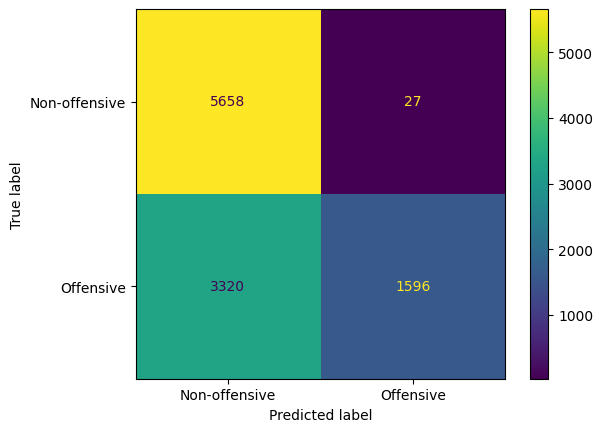

In [26]:
# Decision tree

print(classification_report(y_test_bow, predictions_bow_dt, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_bow, predictions_bow_dt)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.66      0.99      0.79      5685
    Offensive       0.96      0.42      0.58      4916

     accuracy                           0.72     10601
    macro avg       0.81      0.70      0.69     10601
 weighted avg       0.80      0.72      0.70     10601



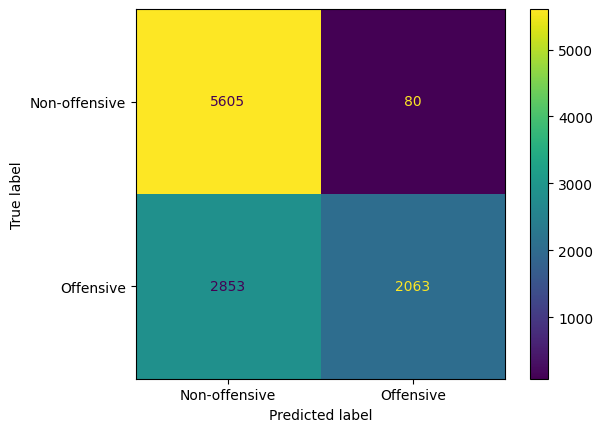

In [27]:
# Random forest

print(classification_report(y_test_bow, predictions_bow_rf, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_bow, predictions_bow_rf)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.84      0.91      0.87      5685
    Offensive       0.89      0.79      0.84      4916

     accuracy                           0.86     10601
    macro avg       0.86      0.85      0.85     10601
 weighted avg       0.86      0.86      0.86     10601



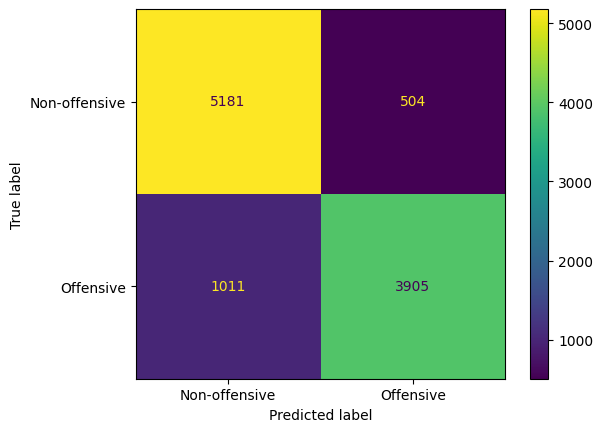

In [28]:
# Naive bayes

print(classification_report(y_test_bow, predictions_bow_nb, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_bow, predictions_bow_nb)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.86      0.80      0.83      5685
    Offensive       0.78      0.85      0.81      4916

     accuracy                           0.82     10601
    macro avg       0.82      0.82      0.82     10601
 weighted avg       0.82      0.82      0.82     10601



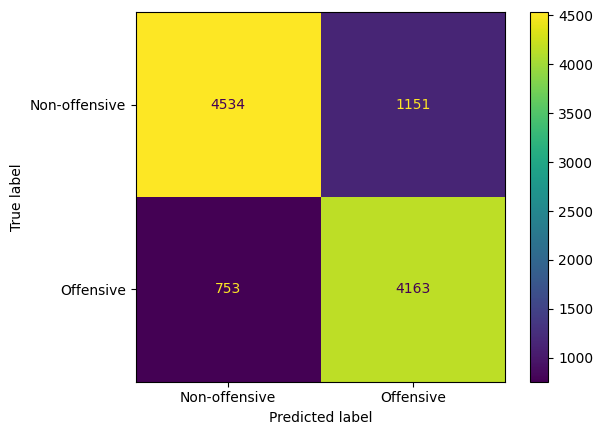

In [32]:
# Multilayer perceptron

print(classification_report(y_test_bow, predictions_bow_mlp, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_bow, predictions_bow_mlp)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

Evaluation of results - Tf-idf

               precision    recall  f1-score   support

Non-offensive       0.63      0.99      0.77      5685
    Offensive       0.98      0.31      0.47      4916

     accuracy                           0.68     10601
    macro avg       0.80      0.65      0.62     10601
 weighted avg       0.79      0.68      0.63     10601



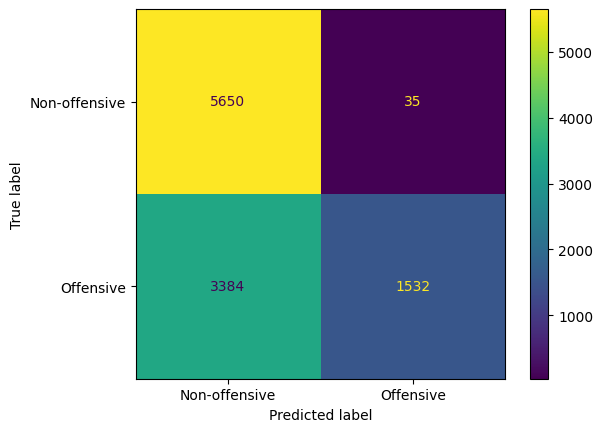

In [ ]:
# Decision trees

print(classification_report(y_test_idf, predictions_idf_dt, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_idf, predictions_idf_dt)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.64      0.98      0.78      5685
    Offensive       0.94      0.36      0.53      4916

     accuracy                           0.70     10601
    macro avg       0.79      0.67      0.65     10601
 weighted avg       0.78      0.70      0.66     10601



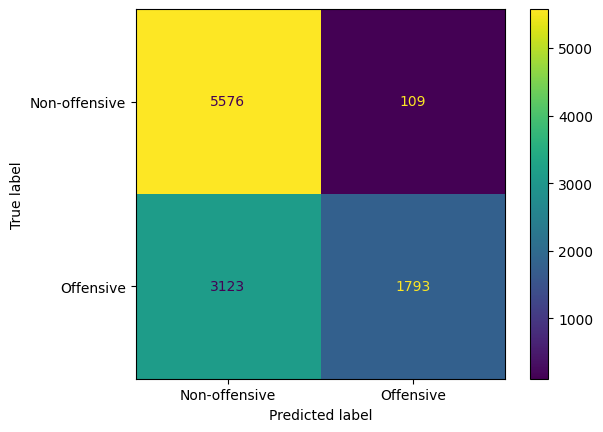

In [ ]:
# Random forest

# Decision trees

print(classification_report(y_test_idf, predictions_idf_rf, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_idf, predictions_idf_rf)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.83      0.91      0.87      5685
    Offensive       0.89      0.78      0.83      4916

     accuracy                           0.85     10601
    macro avg       0.86      0.85      0.85     10601
 weighted avg       0.85      0.85      0.85     10601



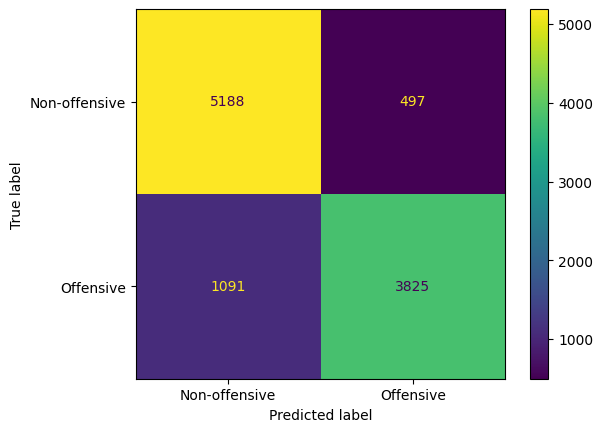

In [ ]:
# Naive bayes

print(classification_report(y_test_idf, predictions_idf_nb, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_idf, predictions_idf_nb)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()

               precision    recall  f1-score   support

Non-offensive       0.78      0.95      0.86      5685
    Offensive       0.92      0.69      0.79      4916

     accuracy                           0.83     10601
    macro avg       0.85      0.82      0.82     10601
 weighted avg       0.84      0.83      0.82     10601



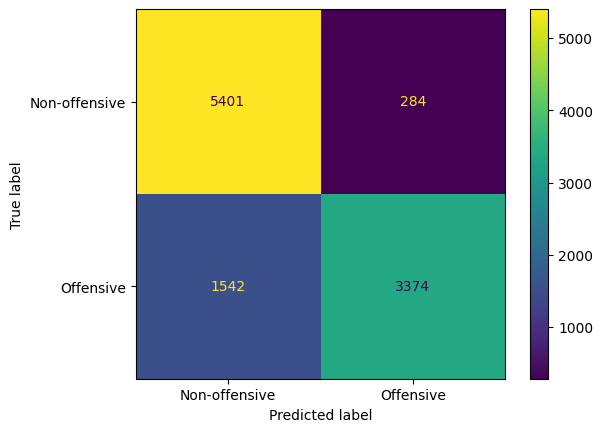

In [ ]:
# Multilayer perceptron

print(classification_report(y_test_idf, predictions_idf_mlp, labels=[False, True], target_names=['Non-offensive', 'Offensive']))


cm = confusion_matrix(y_test_idf, predictions_idf_mlp)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Non-offensive', 'Offensive']).plot()